To start, I modified the dataset to chnage the class data type from object (a list of names) to numeric. The following describes the values: 

0 = ae-aegypti-female
1 = ae-aegypti-male
2 = ae-albopictus-female
3 = ae-albopictus-male 
4 = cx-quinq-female
5 = cx-quinq-male

Load modified dataset

In [20]:
import pandas as pd
from scipy.io import arff

path = 'datasets/INSECTS-gradual_balanced_norm_mod.arff'
data, meta = arff.loadarff(path)

In [21]:
from skmultiflow.data import DataStream
from skmultiflow.drift_detection import EDDM

dataStream = DataStream(data=data, target_idx=33, n_targets=1)

DT = EDDM()

def runHoeffdingTreeClassifier():
    from skmultiflow.trees import HoeffdingTreeClassifier

    window = dataStream.next_sample(batch_size=1000)
    X_train = window[0]
    Y_train = window[1]
    
    for element in  Y_train:
        DT.add_element(element)

    ht = HoeffdingTreeClassifier()
    ht.partial_fit(X_train, Y_train)

    n_samples = 0
    correct_count = 0
    accuracy = []
    time = []
    drift_points = []
    drift_time = []

    while (dataStream.has_more_samples()):
        new_x, new_y = dataStream.next_sample()
        n_samples += 1
        
        y = ht.predict(new_x)

        if new_y == y:
            correct_count += 1

        accuracy.append(correct_count / n_samples)

        time.append(n_samples)
        ht.partial_fit(new_x, new_y)

        DT.add_element(new_y)

        if DT.detected_change():
            drift_points.append(n_samples)
            drift_time.append(1.0)
    
    dataStream.restart()
    return time, accuracy, drift_points, drift_time

In [22]:
hoeffding_tree = runHoeffdingTreeClassifier()

Ploting the accuracy

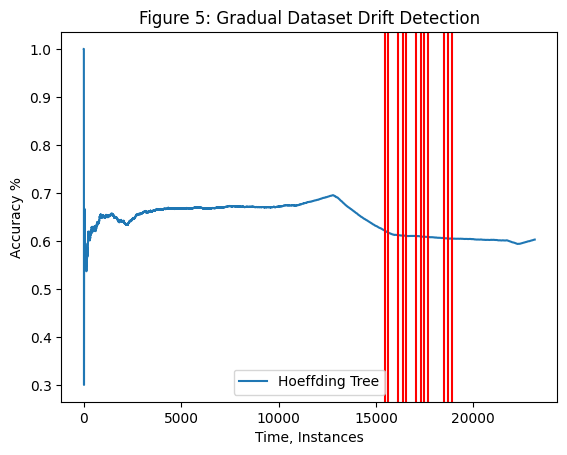

In [23]:
import matplotlib.pyplot as plot

accuracy_plot = plot
accuracy_plot.xlabel('Time, Instances')
accuracy_plot.ylabel('Accuracy %')
accuracy_plot.title('Figure 5: Gradual Dataset Drift Detection')
accuracy_plot.plot(hoeffding_tree[0], hoeffding_tree[1], label = 'Hoeffding Tree')

for x in hoeffding_tree[2] :
    accuracy_plot.axvline(x, 0.0, 1.0, color = 'r')
    
accuracy_plot.legend()
accuracy_plot.show()

In [24]:
print('hoeffding_tree =', hoeffding_tree[1][len(hoeffding_tree[1]) - 1])

hoeffding_tree = 0.6028941684665227
